## Heart rate estimation from Photoplethysmographic (PPG) signals

The advent of wearable devices has made it possible to monitor users heart rate in real time. Monitoring of HR can guide an athelete to adjust his/her training intensity, or enables monitoring users cardiac rhythum.

Most of the devices estimate heart rate (HR) using [Photoplethysmographic](https://en.wikipedia.org/wiki/Photoplethysmograph) PPG signals. The PPG signals are obtained using [pulse oximeters](https://en.wikipedia.org/wiki/Pulse_oximeter) which illumates users skin using a LED and measures the intensity changes in the light reflected from the skin. The intensity changes denotes the PPG signal. The periodicity of the PPG signal corresponds to the cardiac cycle and hence HR can be estimated using PPG signal.

In this notebook, I attempt to estimate HR from a set of data typically obtained from wearable devices. The set of data used in this notebook was made available as a part of [signal processing cup](http://www.signalprocessingsociety.org/spcup2015/index.html) organized during [ICASSP 2015](http://icassp2015.org).

### Experiment description and data format
The experiment used to collect the data is described [here](https://www.dropbox.com/s/kb8whcceih4mn03/Readme.pdf). The data was collected as a part of work done by the authors in [1]. I summarize the description below:

* Two-channel PPG signals, three-axis accelorometer signals and one-channel ECG signal (ground truth) were recorded from subjects.
* All signals were sampled at 125 Hz.
* Each dataset with similar name 'DATA_01_TYPE_01' contains a variable 'sig'. It has 6 rows. The first row is ECG signal, the second and third rows are two channel PPG and the last three rows are accelerometer data.

* The test subjects performed two activities
  * Activity **TYPE01**: rest(30s) -> 8km/h(1min) -> 15km/h(1min) -> 8km/h(1min) -> 15km/h(1min) -> rest(30s)
  * Activity **TYPE02**: rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
  * Each activity begins with a 30 sec rest followed by four 1 minute sessions of running activity and ends with another 30 secs of rest.

**Reference**

[1]: Z. Zhang, Z. Pi, B. Liu, **TROIKA: A general framework for heart rate monitoring using wrist-type photoplethysmographic signals during intensive physical exercise**, IEEE Transactions on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015, DOI: 10.1109/TBME.2014.2359372


In [232]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from scipy.io import loadmat
from scipy.linalg import svd
import scipy.signal as signal
FREQ_SAMPLE = 125  

Lets begin by visualizing first data for Activity **TYPE01**. Using `loadmat` to read the data stored in MATLAB's .mat files. The `loadmat` function returns a `dict` type.

In [233]:
mat_data = loadmat('./training_data/DATA_01_TYPE01.mat')

In [234]:
mat_data.keys()

dict_keys(['__globals__', '__version__', 'sig', '__header__'])

In [235]:
data = mat_data['sig']  # Extract just the matrix
num_sig , num_sample = data.shape
print(num_sig, num_sample)

6 37937


So as expected the 'sig' matrix has 6 rows as described above and for each row there are 37937 samples. Lets visualize the ECG and PPG signal.

<IPython.core.display.Javascript object>


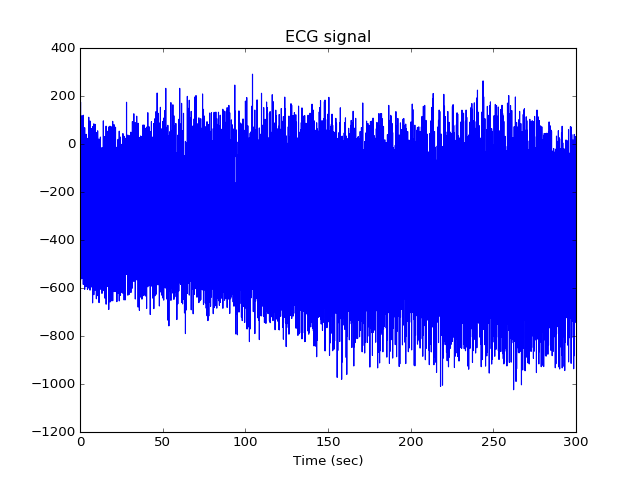

(0, 300)

In [236]:
t = np.linspace(0, num_sample/FREQ_SAMPLE, num_sample)
plt.figure()
plt.plot(t, data[0,:])
plt.title('ECG signal')
plt.xlabel('Time (sec)')
plt.xlim((0, 300))

<IPython.core.display.Javascript object>


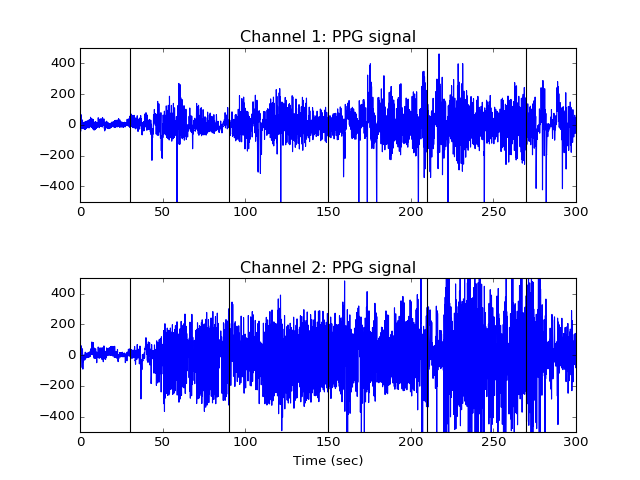

In [237]:
ppg1 = data[1, :]
ppg2 = data[2, :]
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
ax1.plot(t, ppg1)
ax1.axvline(x = 30, color='k')
ax1.axvline(x = 90, color='k')
ax1.axvline(x = 150, color='k')
ax1.axvline(x = 210, color='k')
ax1.axvline(x = 270, color='k')
ax1.set_title('Channel 1: PPG signal')
ax1.set_xlim((0, 300))
ax1.set_ylim((-500, 500))

ax2.plot(t, ppg2)
ax2.set_title('Channel 2: PPG signal')
ax2.set_xlabel('Time (sec)')

ax2.axvline(x = 30, color='k')
ax2.axvline(x = 90, color='k')
ax2.axvline(x = 150, color='k')
ax2.axvline(x = 210, color='k')
ax2.axvline(x = 270, color='k')
ax2.set_xlim((0, 300))
ax2.set_ylim((-500, 500))
f.subplots_adjust(hspace=0.5)


In the above plot, the vertical lines demarcate different activity intervals described above.

<IPython.core.display.Javascript object>


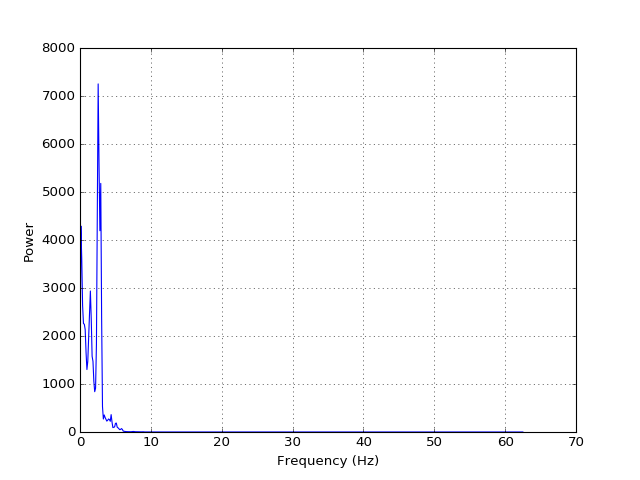

In [238]:
f, spectrum = signal.welch(x=ppg1, fs=FREQ_SAMPLE, window='hanning', scaling='density', nperseg = 1024)
plt.figure()
plt.plot(f, spectrum)
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
    


## Ground truth BPM
Now lets take a look at the calculated'ground true' BPM values estimated from the ECG signal. The ground truth values are stored in 'DATA_01_TYPE01_BPMtrace.mat' file. The BPM values are given for every 8-second time window. Also two successive time windows overlap by 6 seconds.

In [239]:
mat_bpm = loadmat('./training_data/DATA_01_TYPE01_BPMtrace.mat')
data_bpm = mat_bpm['BPM0']

<IPython.core.display.Javascript object>


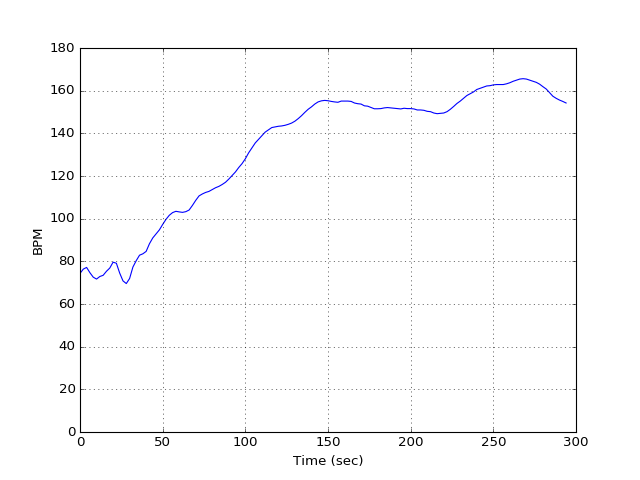

In [240]:
plt.figure()
plt.plot(np.arange(0,len(data_bpm))*2, data_bpm)
plt.ylabel('BPM')
plt.xlabel('Time (sec)')
plt.ylim((0, 180))
plt.grid(True)

## HR BPM estimate using Channel 1 PPG signal
Now lets estimate the BPM HR using the Channel 1 PPG signal above. I begin with a crude approach. The implementation below simply computes the power spectrum for each 8-second segment of the signal and searches for the peak to decide the heart rate. The assumption here is that the heart rate is the dominant periodic signal in the PPG signal. Of course this is a naive assumption knowing that motion artifacts are present in the measurement.

<IPython.core.display.Javascript object>


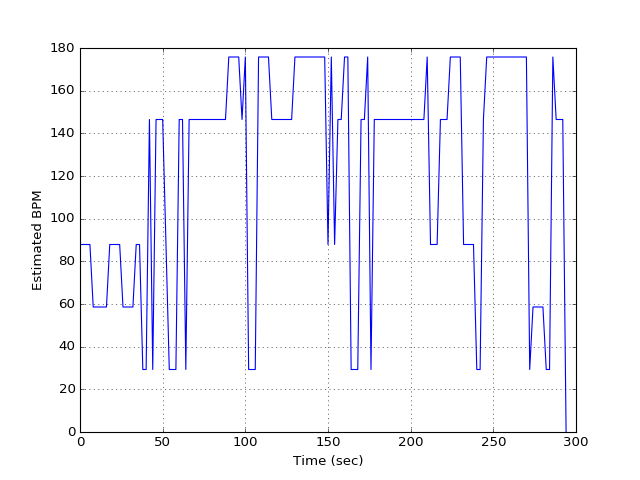

In [241]:
import scipy.signal as signal # Signal processing module
# Load data
window = 8*FREQ_SAMPLE
step = 2*FREQ_SAMPLE
window_number = int((num_sample - window)/step + 1) # Total number of windows 
# Estimate HR for each window
estimate_hr = np.zeros((window_number, 1))
for idx in np.arange(1, window_number):
    segment_cur = ppg1[(idx - 1)*step + 1 : (idx - 1)*step + window]
    f, Pwelch_spec = signal.welch(segment_cur, FREQ_SAMPLE, window='hanning', scaling='spectrum')
    estimate_hr[idx-1] = f[Pwelch_spec == np.max(Pwelch_spec)] #freq corresp to peak power is the estimate

estimate_bpm = estimate_hr*60
plt.figure()
plt.plot(np.arange(0, window_number)*2, estimate_bpm)
plt.xlabel('Time (sec)')
plt.ylabel('Estimated BPM')
plt.ylim((0, 180))
plt.grid(True)

As expected, the BPM estimates using the naive approach exhibits significant variation. Comparing the estimates above to the ground truth results, only a marginal similarity is noticeable. For the initial 30 seconds, the BPM estimates are in the range of 60 - 80 BPM, which makes sense since the subjects are in rest during that time. Beyond the first 30 secs, there is a gradual increase in BPM as the subjects start to exercise. But due to the crude nature of estimation, wildely varying estimates are observed.

## Next step is to improve the HR estimator using the TROIKA approach
TROIKA approach for heart rate estimation is proposed in 

> Zhang, Zhilin, Zhouyue Pi, and Benyuan Liu. "TROIKA: A general framework for heart rate monitoring using wrist-type photoplethysmographic signals during intensive physical exercise." Biomedical Engineering, IEEE Transactions on 62.2 (2015): 522-531.

The TROIKA approach has three different stages,
* Denoising: Remove effects of motion artifact
* Sparse Signal Reconstruction: Process the PPG signal to make it sparse in spectral domain
* Peak detection and tracking: Determine spectral peak and track to estimate the HR.

### Denoising
Denoising is achieved in two steps (1) bandpass filtering and (2) singular spectrum analysis (SSA)

**Bandpass filter**:
First step is to bandpass filter the PPG signal from 0.4 Hz to 5 Hz. This frequency range corresponds to HR range from 24 to 300 bpm which covers all possible range of HR values.

In [242]:
# bandpass FIR filter
w_lower = 0.4
w_upper = 5
b2 = signal.firwin(101, [w_lower, w_upper], pass_zero = False, nyq = FREQ_SAMPLE/2)
w2, h2 = signal.freqz(b2)
ppg1_filtered = signal.convolve(ppg1, b2)

#plt.title('Digital filter frequency response')
#plt.plot(w2*FREQ_SAMPLE/(2*np.pi), 20*np.log10(np.abs(h2)), 'r')
#plt.ylabel('Amplitude Response (dB)')
#plt.xlabel('Frequency (rad/sample)')
#plt.grid()
#plt.ylim(-6, 3)
#plt.axvline(5)
#plt.show()

Lets look at the spectrum of the filtered PPG signal

<IPython.core.display.Javascript object>


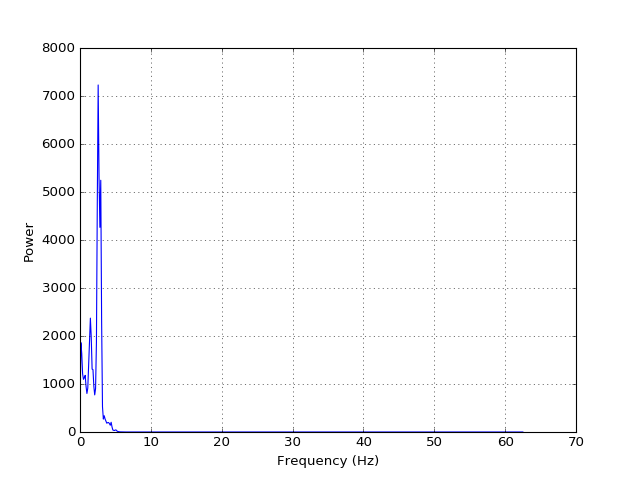

In [243]:
f, spectrum_ppg1_filtered = signal.welch(x=ppg1_filtered, fs=FREQ_SAMPLE, \
                                         window='hanning', scaling='density', nperseg = 1024)
plt.figure()
plt.plot(f, spectrum_ppg1_filtered)
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

After filtering, the spectrum is limited to within 5 Hz as seen above. Next step is to remove motion artifact from the PPG signal using SSA.

In [244]:
# L-trajectory matrix
def trajectory_mat(segment):
    M = window # length of each sequence
    L = int(M/2)
    K = M - L + 1
    Y = np.empty((L, K))
    for k in np.arange(0, K):
        Y[:, k] = segment[k:k + L]
        
    return Y

In [245]:
Y = trajectory_mat(ppg1_filtered[0:window])
U, s, V = svd(Y)


<IPython.core.display.Javascript object>


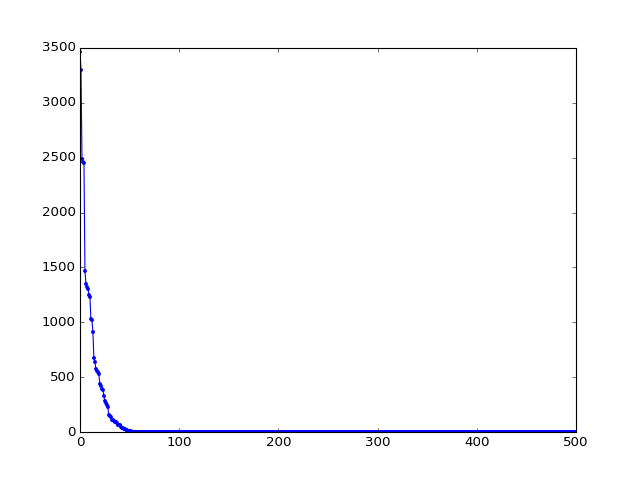

In [246]:
plt.figure()
plt.plot(s, '.-')

### Sparse signal reconstruction
Using FOCUSS algorithm 
$\mathbf{y} = \mathbf{\phi x} + \mathbf{v}$

**TODO**


### Spectral peak detection and tracking

In [247]:
estimate_hr = np.zeros((window_number, 1))
# Initial estimate followed by tracking
#Initialize 

segment_cur = ppg1_filtered[0:window] # First segment
f, P_spec = signal.welch(segment_cur, FREQ_SAMPLE, window='hanning', scaling='spectrum')    
estimate_hr[0] = f[P_spec.argmax()] #freq corresp to peak power is the estimate
Nprev = P_spec.argmax()
#print(Nprev, estimate_hr[0]*60)

In [255]:
for idx in np.arange(1, window_number):
    segment_cur = ppg1_filtered[(idx - 1)*step + 1 : (idx - 1)*step + window]
    f, P_spec = signal.periodogram(segment_cur, fs=FREQ_SAMPLE, window='hanning', scaling='spectrum')   
      
    # Search window
    delta_s = 16
    search_range_1 = np.arange(0 if (Nprev - delta_s) < 0 else (Nprev - delta_s), Nprev + delta_s)
    f_search = f[search_range_1]    
    P_search = P_spec[search_range_1]
    
    search_range_2 = np.arange(1 if (Nprev - delta_s - 1) < 0 else 2*(Nprev - delta_s - 1) + 1, 2*(Nprev + delta_s - 1) + 1)
    f_search_2 = f[search_range_2]
    P_search_2 = P_spec[search_range_2]
        
    N1 = search_range_1[0] + P_search.argmax()
    N2 = search_range_2[0] + P_search_2.argmax()
    Nhat = N1
   # if (N1 == 2*N2):
   #     Nhat = N0
   # else:
   #     Nhat = Nprev
    
    estimate_hr[idx] = f[Nhat] #freq corresp to peak power is the estimate
    Nprev = Nhat

<IPython.core.display.Javascript object>


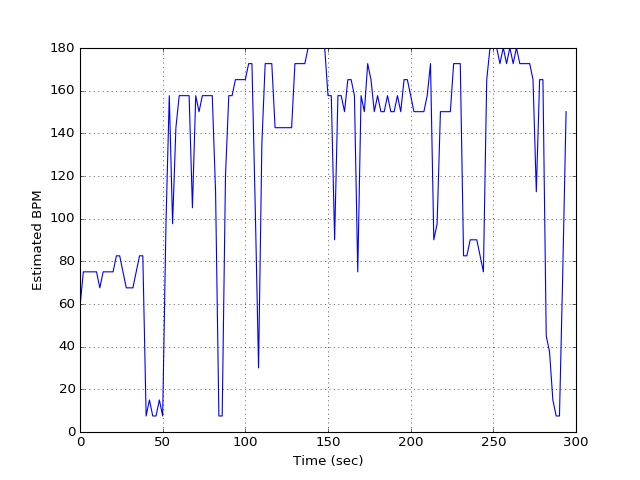

In [256]:
estimate_bpm = estimate_hr*60
plt.figure()
plt.plot(np.arange(0, window_number)*2, estimate_bpm)
plt.xlabel('Time (sec)')
plt.ylabel('Estimated BPM')
plt.ylim((0, 180))
plt.grid(True)